In [514]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm
from functools import reduce
from itertools import chain
import random
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1_l2



pd.options.display.max_rows = None  # Show all rows
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_colwidth = None  # Ensure full content is visible
pd.set_option('display.float_format', '{:.9f}'.format)  # Adjust decimal places as needed

In [515]:
nvda_data = pd.read_csv("full_complete_datasets/NVDA_raw_complete_data.csv")

nvda_data.describe()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_17832\1039184103.py:1: DtypeWarning: Columns (69,81,93,105,117,129,141,155) have mixed types. Specify dtype option on import or set low_memory=False.
  nvda_data = pd.read_csv("full_complete_datasets/NVDA_raw_complete_data.csv")


,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_changeOverTime,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma
count,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6640.000000000,6395.000000000,0.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,0.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,5951.000000000,1607.000000000,6589.000000000,6592.000000000,6592.000000000,6592.000000000,6592.000000000,6592.000000000,6592.000000000,6592.000000000,6592.000000000,5587.000000000,5596.000000000,6620.000000000,6620.000000000,6620.000000000,6620.000000000,6622.000000000,6622.000000000,6622.000000000,6622.000000000,3715.000000000,3715.000000000,3715.000000000,3715.000000000,6629.000000000,6629.000000000,6629.000000000,6629.000000000,6629.000000000,6629.000000000,6629.000000000,6629.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1269.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1270.000000000,1

# Data Cleaning & Preprocessing

In [516]:
nvda_duplicates = nvda_data.duplicated()
print("Duplicate rows in your data: ")
nvda_duplicates.value_counts()

Duplicate rows in your data: 


False    6603
True       37
Name: count, dtype: int64

In [517]:
df_duplicates_rows = nvda_data[nvda_data.duplicated(keep=False)]

# Displaying examples of duplicated rows
df_duplicates_rows.head(10)

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
124,20-07-1999,21.000000000,21.380000000,20.250000000,21.380000000,372400,0.040126771,0.038693672,0.040852874,178751910,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.640000000,4.640000000,4.960000000,5.430000000,5.480000000,5.540000000,5.800000000,5.650000000,6.180000000,5.890000000,NaN,338.500000000,65.000000000,336.750000000,338.500000000,0.769500000,14313.000000000,0.781000000,0.769500000,NaN,NaN,NaN,NaN,5.060000000,0.000000000,5.040000000,5.060000000,253.350000000,0.000000000,253.250000000,253.350000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NVDA,0.043750200,100.000000000,0.043750200,0.043750200,0.000000000,0.000000000,0.043750200,-33.334755525,0.043750200,neutral,neutral,NaN
125,20-07-1999,21.000000000,21.380000000,20.250000000,21.380000000,372400,0.040126771,0.038693672,0.040852874,178751910,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.640000000,4.640000000,4.960000000,5.430000000,5.480000000,5.540000000,5.800000000,5.650000000,6.180000000,5.890000000,NaN,338.500000000,65.000000000,336.750000000,338.500000000,0.769500000,14313.000000000,0.781000000,0.769500000,NaN,NaN,NaN,NaN,5.060000000,0.000000000,5.040000000,5.060000000,253.350000000,0.000000000,253.250000000,253.35000

In [518]:
# dropping all duplicates
nvda_data = nvda_data.drop_duplicates()

# converting date column to datetime
nvda_data['date'] = pd.to_datetime(nvda_data['date'], format="%d-%m-%Y")

In [519]:
nvda_data.head()

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
0,1999-01-22,19.690000000,23.440000000,18.630000000,21.000000000,5655600,0.037623625,0.035598178,0.040126771,2714686642,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.360000000,4.440000000,4.460000000,4.590000000,4.580000000,4.540000000,4.730000000,4.640000000,5.380000000,5.090000000,NaN,321.050000000,38.000000000,320.000000000,321.050000000,0.657000000,6178.000000000,0.658500000,0.657000000,NaN,NaN,NaN,NaN,5.115000000,0.000000000,5.115000000,5.115000000,286.450000000,0.000000000,287.450000000,286.450000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral,neutral,NaN
1,1999-01-25,21.750000000,22.000000000,19.690000000,21.250000000,1063500,0.041559870,0.037623625,0.040604471,510479744,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.440000000,4.450000000,4.480000000,4.590000000,4.580000000,4.550000000,4.740000000,4.670000000,5.400000000,5.120000000,NaN,325.000000000,127.000000000,321.050000000,325.000000000,0.653500000,5340.000000000,0.652000000,0.653500000,NaN,NaN,NaN,NaN,5.185000000,0.000000000,5.100000000,5.185000000,287.850000000,0.000000000,286.450000000,287.850000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [520]:
nvda_data.columns

Index(['date', 'NVDA_close', 'NVDA_high', 'NVDA_low', 'NVDA_open',
       'NVDA_traded_volume', 'NVDA_adjClose', 'NVDA_adjLow', 'NVDA_adjOpen',
       'NVDA_adj_traded_volume',
       ...
       'dema', 'ema', 'rsi', 'standardDeviation', 'tema', 'williams', 'wma',
       'NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment',
       'NVDA_twitter_social_sentiment'],
      dtype='object', length=156)

In [521]:
# These columns just represents the company's symbol and currency labels and is not useful so we drop it
nvda_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)

In [522]:
# Function to obtain percentages of missing values 
def percent_missing(df):
    nan_percent = 100 * df.isnull().sum() / len(df)
    nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

    return nan_percent

# Function to plot out missing value percentages by column
def show_percent_missing(df):
    nan_percent = percent_missing(df)

    plt.figure(figsize=(24, 8))

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

In [523]:
# Identifying values in this column that are not useful which we were generated by chat-GPT
nvda_data['NVDA_stock_news_sentiment'].unique()

array(['neutral', 'weakly_positive', 'strongly_positive',
       'weakly_negative', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for specific historical dates without direct access to news archives from that time.",
       "i'm sorry, but i can’t provide that specific information."],
      dtype=object)

In [524]:
# Replacing values that are not useful as missing 
nvda_data['NVDA_stock_news_sentiment'][nvda_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


# creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

# filling values as missing excluding those in the exclusion list
nvda_data['NVDA_press_release_sentiment'] = nvda_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(nvda_data['NVDA_stock_news_sentiment'].unique())
print(nvda_data['NVDA_press_release_sentiment'].unique())

['neutral' 'weakly_positive' 'strongly_positive' 'weakly_negative'
 'strongly_negative' nan]
['neutral' 'strongly_positive' 'weakly_positive' 'weakly_negative'
 'strongly_negative' nan]


C:\Users\ekf98\AppData\Local\Temp\ipykernel_17832\4286128257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_data['NVDA_stock_news_sentiment'][nvda_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


In [525]:
# Creating a year and month column
nvda_data['month'] = nvda_data['date'].dt.month
nvda_data['year'] = nvda_data['date'].dt.year


# creating a function to classify the months based on the season
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    

# Creating a season column 
nvda_data['season'] = nvda_data['month'].apply(season)

nvda_data[['date', 'year', 'month', 'season']].sample(20)

,date,year,month,season
1494,2004-12-08,2004,12,Winter
4291,2015-12-03,2015,12,Winter
241,1999-12-31,1999,12,Winter
3524,2012-11-28,2012,11,Fall
3317,2012-02-03,2012,2,Winter
1092,2003-05-12,2003,5,Spring
3965,2014-08-22,2014,8,Summer
3188,2011-08-03,2011,8,Summer
5385,2020-03-26,2020,3,Spring
5052,2018-11-29,2018,11,Fall


In [526]:
# # Creating Subplots Grid

# fig, axes = plt.subplots(nrows=(len(nvda_data.columns) // 3) + 1, ncols=3, figsize=(15, 5 * ((len(nvda_data.columns) // 3) + 1)))

# # Flattening axes for easy iteration
# axes = axes.flatten()

# # plotting each numeric column against 'SalePrice'
# for i, col in enumerate(nvda_data.columns):
#     sns.scatterplot(x=nvda_data[col], y =nvda_data['NVDA_close'], ax=axes[i])
#     axes[i].set_title(f'{col} vs NVDA_close')

# # Hiding any extra subplots where numeric columns are not a multiple of 3
# for i in range(len(nvda_data.columns), len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

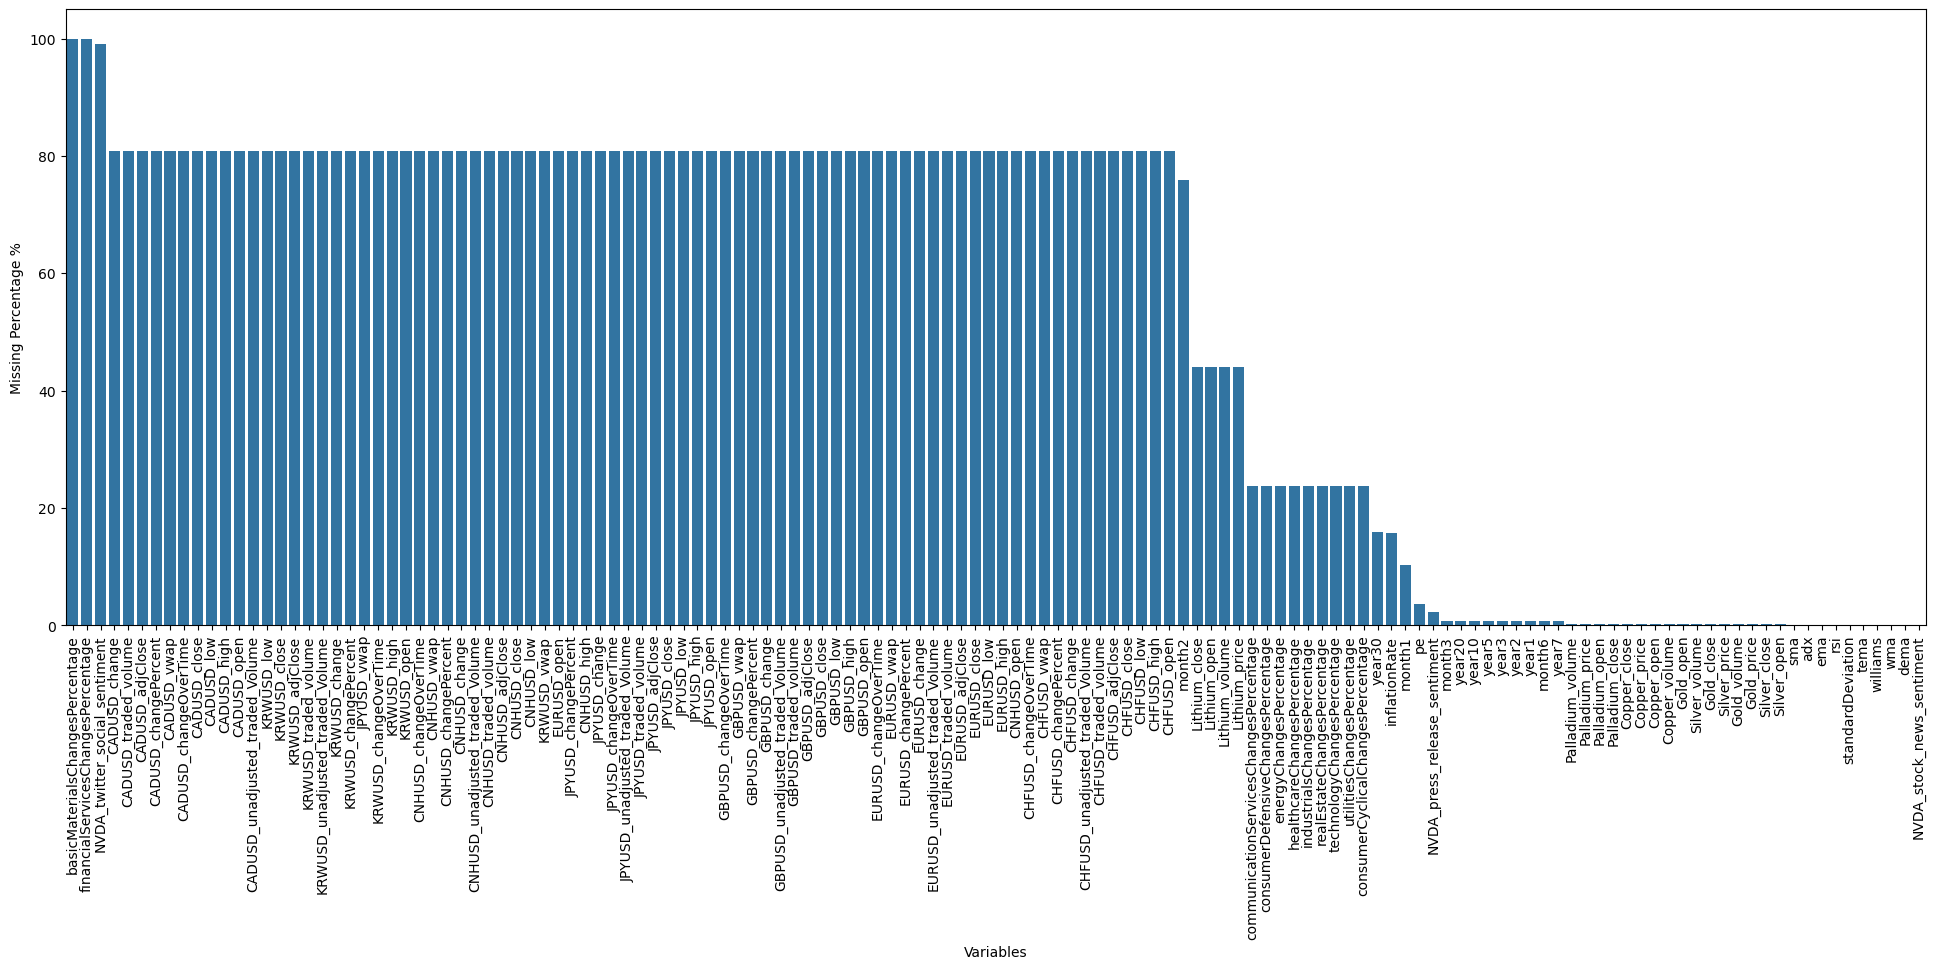

In [527]:
show_percent_missing(nvda_data)

In [528]:
percent_missing(nvda_data)

basicMaterialsChangesPercentage          100.000000000
financialServicesChangesPercentage       100.000000000
NVDA_twitter_social_sentiment             99.091322126
CADUSD_change                             80.902620021
CADUSD_traded_volume                      80.902620021
CADUSD_adjClose                           80.902620021
CADUSD_changePercent                      80.902620021
CADUSD_vwap                               80.902620021
CADUSD_changeOverTime                     80.902620021
CADUSD_close                              80.902620021
CADUSD_low                                80.902620021
CADUSD_high                               80.902620021
CADUSD_open                               80.902620021
CADUSD_unadjusted_traded_Volume           80.902620021
KRWUSD_low                                80.887475390
KRWUSD_close                              80.887475390
KRWUSD_adjClose                           80.887475390
KRWUSD_traded_volume                      80.887475390
KRWUSD_una

In [529]:
nan_percent = 100 * nvda_data.isnull().sum() / len(nvda_data)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

cols_to_drop = nan_percent[nan_percent >= 75].index

nvda_data.drop(columns=cols_to_drop, inplace=True)

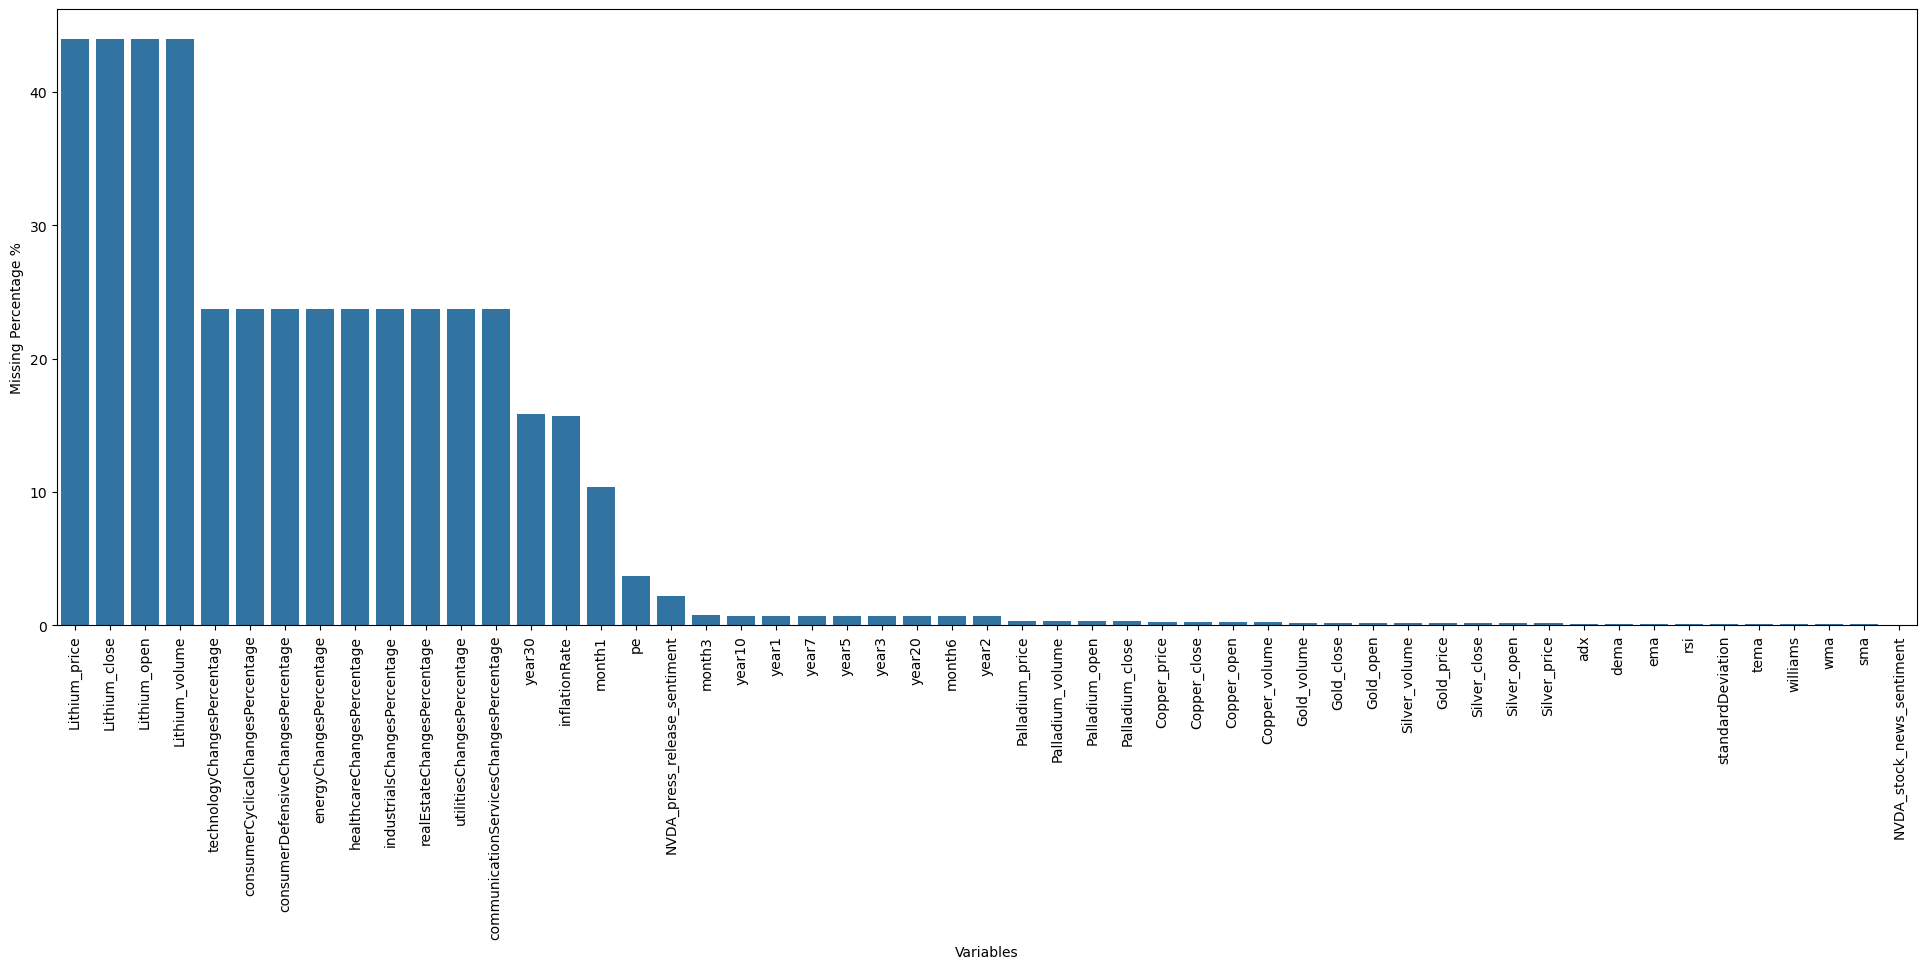

In [530]:
show_percent_missing(nvda_data)

In [531]:
percent_missing(nvda_data)

Lithium_price                            44.025442980
Lithium_close                            44.025442980
Lithium_open                             44.025442980
Lithium_volume                           44.025442980
technologyChangesPercentage              23.716492503
consumerCyclicalChangesPercentage        23.716492503
consumerDefensiveChangesPercentage       23.716492503
energyChangesPercentage                  23.716492503
healthcareChangesPercentage              23.716492503
industrialsChangesPercentage             23.716492503
realEstateChangesPercentage              23.716492503
utilitiesChangesPercentage               23.716492503
communicationServicesChangesPercentage   23.716492503
year30                                   15.856428896
inflationRate                            15.704982584
month1                                   10.343783129
pe                                        3.665000757
NVDA_press_release_sentiment              2.226260791
month3                      

In [532]:
nvda_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6603 entries, 0 to 6639
Data columns (total 68 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date                                    6603 non-null   datetime64[ns]
 1   NVDA_close                              6603 non-null   float64       
 2   NVDA_high                               6603 non-null   float64       
 3   NVDA_low                                6603 non-null   float64       
 4   NVDA_open                               6603 non-null   float64       
 5   NVDA_traded_volume                      6603 non-null   int64         
 6   NVDA_adjClose                           6603 non-null   float64       
 7   NVDA_adjLow                             6603 non-null   float64       
 8   NVDA_adjOpen                            6603 non-null   float64       
 9   NVDA_adj_traded_volume                  6603 non-null   i

In [533]:
# Filling missing values of NVDA_stock_news_sentiment with mode by each year and month
nvda_data['NVDA_stock_news_sentiment']  = nvda_data.groupby(['year', 'month'])['NVDA_stock_news_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of NVDA_press_release_sentiment with mode by each year and month
nvda_data['NVDA_press_release_sentiment']  = nvda_data.groupby(['year', 'month'])['NVDA_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))


# Grouping by year and month or just the year and then filling with the mode or median
def fill_values(feature, dataset):

    dataset[feature] = dataset.groupby(['year', 'month'])[feature].transform(lambda value: value.fillna(value.median()))

    if dataset[feature].isnull().any():
        dataset[feature] = dataset.groupby('year')[feature].transform(lambda value: value.fillna(value.median()))
        

cols_to_fill = ['Gold_volume', 'Gold_close', 'Gold_open', 'Gold_price', 'Copper_close','Copper_price',
                'Copper_volume', 'Copper_open', 'Palladium_price', 'Palladium_volume', 'Palladium_open',
                'Palladium_close', 'Silver_close', 'Silver_open', 'Silver_volume', 'Silver_price',
                'Lithium_volume', 'Lithium_close', 'Lithium_open', 'Lithium_price', 'sma', 'adx', 'dema',
                'ema', 'rsi', 'standardDeviation', 'tema', 'williams', 'wma', 'month3', 'year3', 'year5',
                'year7', 'year10', 'year20', 'year2', 'year1', 'month6', 'realEstateChangesPercentage',
                'utilitiesChangesPercentage', 'communicationServicesChangesPercentage', 'technologyChangesPercentage',
                'industrialsChangesPercentage', 'healthcareChangesPercentage', 'energyChangesPercentage',  
                'consumerDefensiveChangesPercentage', 'consumerCyclicalChangesPercentage', 'year30',
                'inflationRate', 'month1', 'pe']

# Filling columns as defined in function
for col in cols_to_fill:
    fill_values(col, nvda_data)


# Filling inflation rate and interest rates with their respective medians
nvda_data['inflationRate'] = nvda_data['inflationRate'].fillna(nvda_data['inflationRate'].median())
nvda_data['year30'] = nvda_data['year30'].fillna(nvda_data['year30'].median())
nvda_data['month1'] = nvda_data['month1'].fillna(nvda_data['month1'].median())

In [534]:
# cols_to_map = ['AAPL_stock_news_sentiment', 'NVDA_stock_news_sentiment', 'AAPL_press_release_sentiment', 'NVDA_press_release_sentiment'] 


# category_mapping = {'neutral': 0, 'weakly_positive': 0.5, 'strongly_positive': 1, 'weakly_negative': -0.5, 'strongly_negative': 1}

# # mapping using lambda function
# aapl_data[cols_to_map] = aapl_data[cols_to_map].apply(lambda col: col.map(category_mapping))

In [535]:
percent_missing(nvda_data)

Lithium_price    41.905194609
Lithium_volume   41.905194609
Lithium_open     41.905194609
Lithium_close    41.905194609
dtype: float64

In [536]:
# Select only numerical columns
numeric_data = nvda_data.select_dtypes(include=['float64', 'int32', 'int64'])

# Compute correlation of 'Lithium_price' with all other numeric columns
lithium_corr = numeric_data.corr()['Lithium_price'].dropna()

# Compute correlation of 'Lithium_close' with all other numeric columns
lithium_close = numeric_data.corr()['Lithium_close'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_open = numeric_data.corr()['Lithium_open'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_vol = numeric_data.corr()['Lithium_volume'].dropna()

# Filter only correlations with absolute value > 0.70
strong_corr = lithium_corr[abs(lithium_corr) > 0.70]

strong_corr_close = lithium_close[abs(lithium_close) > 0.70]

strong_corr_open = lithium_open[abs(lithium_open) > 0.70]

strong_corr_vol = lithium_vol[abs(lithium_vol) > 0.50]


# Print correlation values sorted in descending order
print(strong_corr.sort_values(ascending=False, key=abs), strong_corr_close.sort_values(ascending=False, key=abs), 
      strong_corr_open.sort_values(ascending=False, key=abs), strong_corr_vol.sort_values(ascending=False, key=abs))

Lithium_price   1.000000000
Lithium_close   1.000000000
Lithium_open    0.999540518
Copper_price    0.708571244
Copper_close    0.708571244
Copper_open     0.707160101
Name: Lithium_price, dtype: float64 Lithium_price   1.000000000
Lithium_close   1.000000000
Lithium_open    0.999540518
Copper_price    0.708571244
Copper_close    0.708571244
Copper_open     0.707160101
Name: Lithium_close, dtype: float64 Lithium_open    1.000000000
Lithium_price   0.999540518
Lithium_close   0.999540518
Copper_price    0.708361199
Copper_close    0.708361199
Copper_open     0.707412306
Name: Lithium_open, dtype: float64 Lithium_volume    1.000000000
Lithium_open      0.697392606
Lithium_price     0.697043543
Lithium_close     0.697043543
Palladium_open    0.632903291
Palladium_price   0.631794348
Palladium_close   0.631794348
year              0.568145316
NVDA_high         0.548338843
NVDA_open         0.547652433
NVDA_close        0.546892928
NVDA_low          0.545964769
Silver_volume     0.520894775

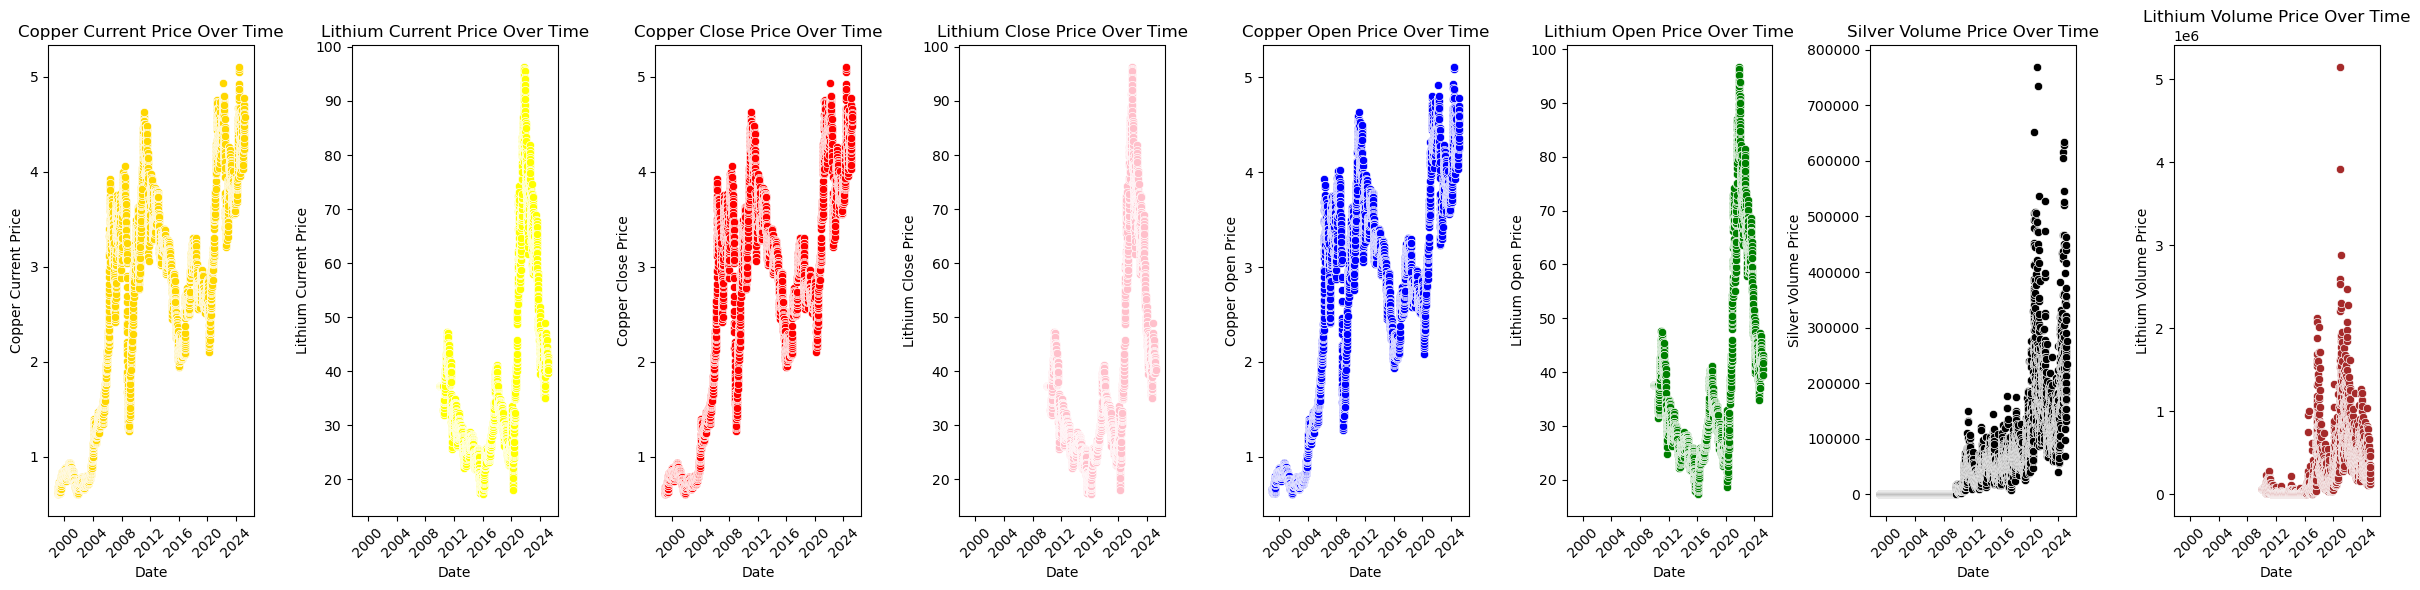

In [537]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()


In [538]:

def linear_reg_filling(col_to_fill, col_to_use, dataset):
    """ 
    col_to_fill: This is essentially the column to fill missing values on 
    col_to_use: This is the column that is trained on the linear model to create predictions on col_to_fill
    dataset: The dataset to use 
    """

    # The correlation between copper and lithium features are high (0.70). Hence, I would use a linear regression model to predict the missing values of lithium and fill them up
    # A similar correlation is shown for the other features plotted above
    from sklearn.linear_model import LinearRegression


    # Add a small constant to avoid issues with log(0)
    epsilon = 1e-5

    dataset[f"{col}_log"] = np.log(dataset[col_to_fill] + epsilon)

    # Extract rows with missing column values
    missing_data = dataset[dataset[col_to_fill].isna()]

    # Use non-missing values for fitting the regression model
    train_data = dataset.dropna(subset=[col_to_fill])

    # Reshape data to 2D (needed for sklearn)
    X_train = train_data[[col_to_use]]  # Copper as independent variable
    y_train = train_data[f"{col}_log"]  # Lithium as dependent variable

    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict Lithium values for the missing data
    X_missing = missing_data[[col_to_use]]
    predicted_col_log = model.predict(X_missing)

    # Apply inverse log transformation to predict original Lithium values
    predictions = np.exp(predicted_col_log) - epsilon

    # Fill missing Lithium values with the predicted values
    dataset.loc[dataset[col_to_fill].isna(), col_to_fill] = predictions


linear_reg_filling('Lithium_price', 'Copper_price', nvda_data)
linear_reg_filling('Lithium_close', 'Copper_close', nvda_data)
linear_reg_filling('Lithium_open', 'Copper_open', nvda_data)
linear_reg_filling('Lithium_volume', 'Silver_volume', nvda_data)

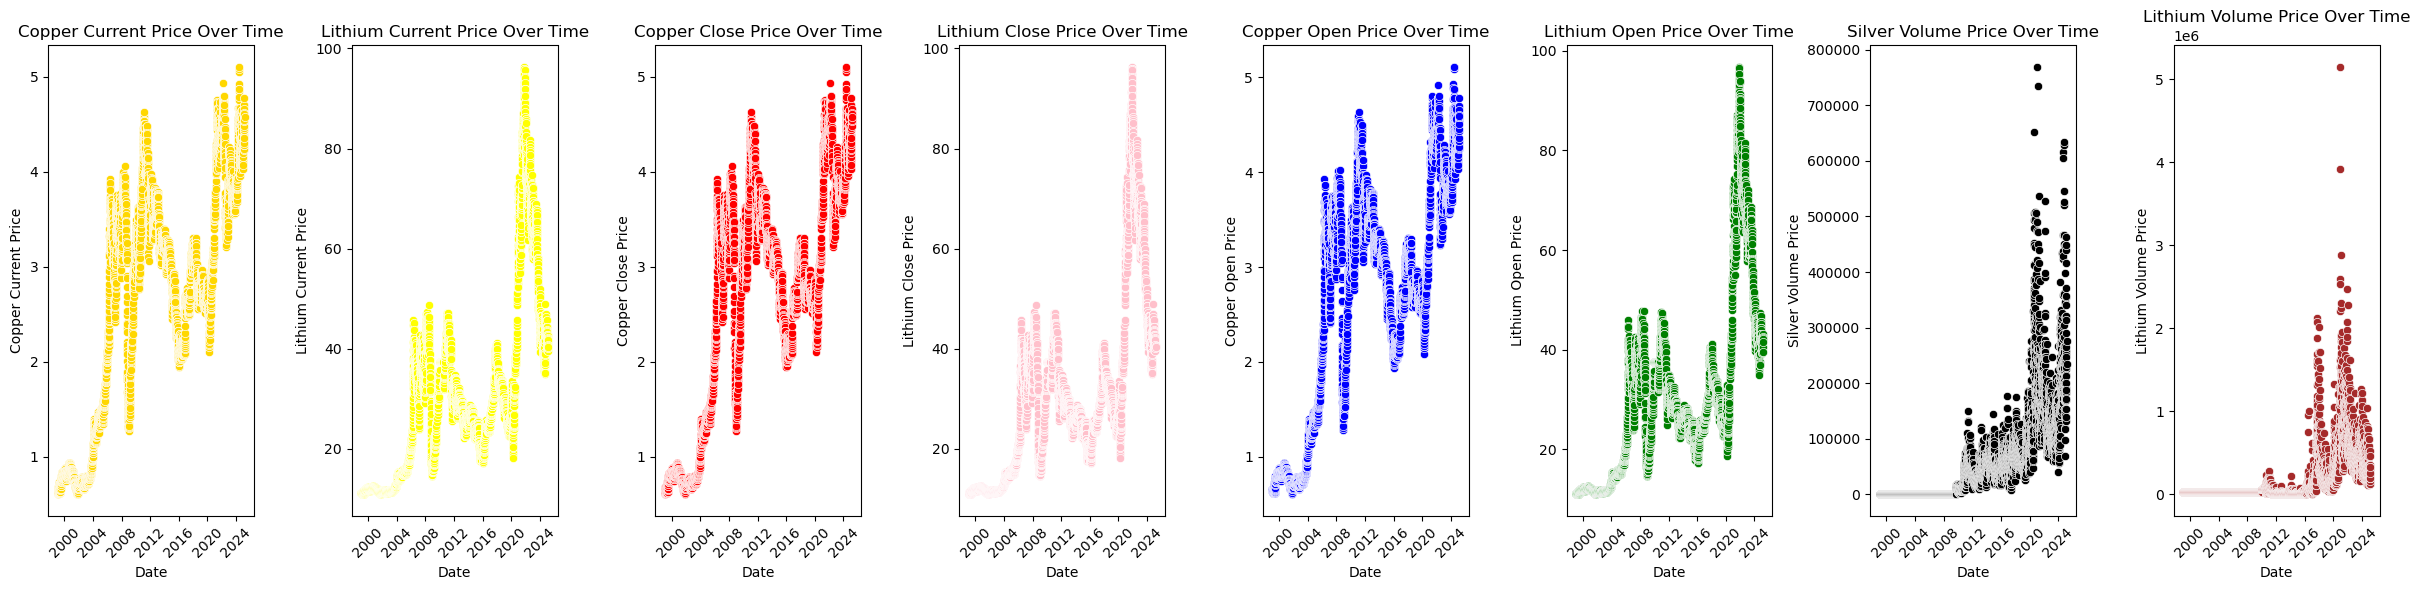

In [539]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=nvda_data['date'], y=nvda_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

In [540]:
nvda_data.drop(columns='pe_log', inplace=True)

percent_missing(nvda_data)

Series([], dtype: float64)

In [541]:
nvda_data.isnull().sum()

date                                      0
NVDA_close                                0
NVDA_high                                 0
NVDA_low                                  0
NVDA_open                                 0
NVDA_traded_volume                        0
NVDA_adjClose                             0
NVDA_adjLow                               0
NVDA_adjOpen                              0
NVDA_adj_traded_volume                    0
NVDA_divCash                              0
NVDA_splitFactor                          0
pe                                        0
communicationServicesChangesPercentage    0
consumerCyclicalChangesPercentage         0
consumerDefensiveChangesPercentage        0
energyChangesPercentage                   0
healthcareChangesPercentage               0
industrialsChangesPercentage              0
realEstateChangesPercentage               0
technologyChangesPercentage               0
utilitiesChangesPercentage                0
month1                          

In [542]:
# creating a separate copy for other models that do not require creating lagged features
separate_nvda_data = nvda_data.copy()

In [543]:
nvda_data.sample(8).sort_values('date')

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
846,2002-05-23,35.730000000,38.240000000,34.600000000,38.160000000,21306500,0.273091339,0.264454529,0.291664301,2556778721,0.000000000,1.000000000,400.571322900,1.946220000,1.509750000,-0.056420000,1.280050000,-6.976020000,1.221180000,1.793260000,1.065570000,1.231960000,1.730000000,1.740000000,1.910000000,2.380000000,3.280000000,3.800000000,4.460000000,4.870000000,5.160000000,5.830000000,5.400000000,2.190000000,354.000000000,226.000000000,360.000000000,354.000000000,0.736000000,8827.000000000,0.728500000,0.736000000,11.575484019,29891.782535737,11.566209041,11.575484019,4.820000000,0.000000000,4.825000000,4.820000000,322.050000000,0.000000000,317.950000000,322.050000000,0.297750000,100.000000000,0.297750000,0.297750000,0.000000000,0.000000000,0.297750000,-68.951878708,0.297750000,neutral,neutral,5,2002,Spring
1725,2005-11-03,34.650000000,35.500000000,34.370000000,35.300000000,3875600,0.264836688,0.262696594,0.269804765,465071767,0.000000000,1.000000000,4.394825316,0.129170000,-0.811370000,-0.052830000,1.595690000,5.732530000,2.470050000,-0.383060000,0.000120000,0.091450000,3.810000000,3.940000000,4.270000000,4.330000000,4.470000000,4.500000000,4.550000000,4.590000000,4.650000000,4.940000000,3.730000000,2.620000000,231.900000000,610.000000000,227.300000000,231.900000000,1.827000000,11801.000000000,1.826500000,1.827000000,18.539537087,29891.782535737,18.566115561,18.539537087,7.575000000,0.000000000,7.535000000,7.575000000,461.100000000,0.000000000,463.150000000,461.100000000,0.288750000,100.000000000,0.288750000,0.288750000,0.000000000,0.000000000,0.288750000,-75.239107333,0.288750000,neutral,neutral,11,2005,Fall
1945,2006-09-14,28.990000000,29.500000000,28.610000000,28.960000000,7146867,0.443152416,0.437343588,0.442693824,428811805,0.000000000,1.000000000,9.071012563,0.002300000,1.283915000,-0.370040000,-0.259695000,-0.830965000,-0.838350000,-0.342260000,-0.000085000,-0.363295000,4.810000000,4.950000000,5.120000000,5.020000000,4.830000000,4.770000000,4.740000000,4.750000000,4.790000000,4.990000000,4.920000000,2.440000000,327.200000000,672.000000000,319.000000000,327.200000000,3.374500000,5981.000000000,3.385000000,3.374500000,36.161889611,29891.782535737,36.345448912,36.161889611,10.695000000,0.000000000,11.185000000,10.695000000,575.250000000,0.000000000,589.850000000,575.250000000,0.483170000,100.000000000,0.483170000,0.483170000,0.000000000,0.000000000,0.483170000,-57.316250843,0.483170000,neutral,neutral,9,2006,Fall
2164,2007-07-30,45.490000000,45.560000000,44.400000000,44.410000000,8969267,0.695377833,0.678715669,0.678868533,538155750,0.000000000,1.000000000,10.417816370,0.930400000,0.086810000,0.467160000,1.021720000,-1.483190000,-2.083270000,0.938890000,0.027190000,0.582070000,4.950000000,4.960000000,5.000000000,4.870000000,4.590000000,4.570000000,4.640000000,4.710000000,4.820000000,5.050000000,4.970000000,2.330000000,367.300000000,1232.000000000,363.700000000,367.300000000,3.588500000,7456.000000000,3.529500000,3.588500000,39.662086286,29891.782535737,38.681060684,39.662086286,12.885000000,0.000000000,12.655000000,12.885

In [544]:
def created_lagged_features_daily(data, target_col, external_features, max_lag=10):
    df = data.copy()

    # lag target feature (stock price) from 1 to 7 days
    # for lag in range(1, 8):
    for lag in range(1, max_lag + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Selectively lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            # attempting to capture long-term dependency with max lags
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        
        elif feature == 'Silver_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_press_release_sentiment':
            # lagging very short-term dependencies for news sentiments as news trends change often
            # for lag in range(1, 6):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            # lagging short-term dependencies for press releases
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    df.dropna(inplace=True) # dropping all NaN values after shifting
    
    return df

In [545]:
external_features = ['Silver_price', 'inflationRate', 'NVDA_stock_news_sentiment', 'Gold_price', 'NVDA_press_release_sentiment']

nvda_data = created_lagged_features_daily(nvda_data, 'NVDA_close', external_features=external_features)

nvda_data['day'] = nvda_data['date'].dt.day

nvda_data.head()

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season,NVDA_close_lag_1,NVDA_close_lag_2,NVDA_close_lag_3,NVDA_close_lag_4,NVDA_close_lag_5,NVDA_close_lag_6,NVDA_close_lag_7,NVDA_close_lag_8,NVDA_close_lag_9,NVDA_close_lag_10,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,NVDA_stock_news_sentiment_lag_1,NVDA_stock_news_sentiment_lag_2,NVDA_stock_news_sentiment_lag_3,NVDA_stock_news_sentiment_lag_4,NVDA_stock_news_sentiment_lag_5,NVDA_stock_news_sentiment_lag_6,NVDA_stock_news_sentiment_lag_7,NVDA_stock_news_sentiment_lag_8,NVDA_stock_news_sentiment_lag_9,NVDA_stock_news_sentiment_lag_10,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,Gold_price_lag_10,NVDA_press_release_sentiment_lag_1,NVDA_press_release_sentiment_lag_2,NVDA_press_release_sentiment_lag_3,NVDA_press_release_sentiment_lag_4,NVDA_press_release_sentiment_lag_5,NVDA_press_release_sentiment_lag_6,NVDA_press_release_sentiment_lag_7,NVDA_press_release_sentiment_lag_8,NVDA_press_release_sentiment_lag_9,NVDA_press_release_sentiment_lag_10,day
10,1999-02-05,19.810000000,20.000000000,19.060000000,19.560000000,285100,0.037852921,0.036419822,0.037375221,136847931,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.500000000,4.600000000,4.660000000,4.800000000,4.850000000,4.880000000,5.040000000,4.940000000,5.610000000,5.340000000,2.190000000,346.000000000,796.000000000,357.000000000,346.000000000,0.666000000,17079.000000000,0.667000000,0.666000000,11.230894179,29891.782535737,11.263648993,11.230894179,5.665000000,0.000000000,5.805000000,5.665000000,288.550000000,0.000000000,289.450000000,288.550000000,0.041276200,100.000000000,0.041276200,0.041276200,100.000000000,0.000000000,0.041276200,-20.003071882,0.041276200,neutral,neutral,2,1999,Winter,19.250000000,18.250000000,17.880000000,19.380000000,19.000000000,19.940000000,20.000000000,20.060000000,21.750000000,19.690000000,5.765000000,5.535000000,5.465000000,5.320000000,5.245000000,5.235000000,5.095000000,5.115000000,5.185000000,5.115000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,2.190000000,neutral,weakly_positive,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,289.450000000,287.550000000,288.450000000,288.850000000,286.150000000,284.250000000,283.000000000,286.150000000,287.850000000,286.450000000,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,5
11,1999-02-08,19.130000000,20.000000000,19.130000000,19.940000000,321000,0.036553578,0.036553578,0.038101324,154079922,0.000000000,1.000000000,82.589342710,0.853720000,-0.3

In [546]:
nvda_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6593 entries, 10 to 6639
Columns: 129 entries, date to day
dtypes: datetime64[ns](1), float64(100), int32(3), int64(2), object(23)
memory usage: 6.5+ MB


In [547]:
# Obtainig Dummies
nvda_data = pd.get_dummies(nvda_data, drop_first=True)

num_cols = list(nvda_data.select_dtypes(include=['float64', 'int64', 'int32']).columns)

num_cols.remove('NVDA_close')

print(num_cols)

print(len(num_cols), len(nvda_data.columns))

['NVDA_high', 'NVDA_low', 'NVDA_open', 'NVDA_traded_volume', 'NVDA_adjClose', 'NVDA_adjLow', 'NVDA_adjOpen', 'NVDA_adj_traded_volume', 'NVDA_divCash', 'NVDA_splitFactor', 'pe', 'communicationServicesChangesPercentage', 'consumerCyclicalChangesPercentage', 'consumerDefensiveChangesPercentage', 'energyChangesPercentage', 'healthcareChangesPercentage', 'industrialsChangesPercentage', 'realEstateChangesPercentage', 'technologyChangesPercentage', 'utilitiesChangesPercentage', 'month1', 'month3', 'month6', 'year1', 'year2', 'year3', 'year5', 'year7', 'year10', 'year20', 'year30', 'inflationRate', 'Palladium_price', 'Palladium_volume', 'Palladium_open', 'Palladium_close', 'Copper_price', 'Copper_volume', 'Copper_open', 'Copper_close', 'Lithium_price', 'Lithium_volume', 'Lithium_open', 'Lithium_close', 'Silver_price', 'Silver_volume', 'Silver_open', 'Silver_close', 'Gold_price', 'Gold_volume', 'Gold_open', 'Gold_close', 'sma', 'adx', 'dema', 'ema', 'rsi', 'standardDeviation', 'tema', 'williams

In [548]:
# Normalize the data as stock prices have a lower bound of zero
scaler = MinMaxScaler(feature_range=(0, 1))

nvda_data[num_cols] = scaler.fit_transform(nvda_data[num_cols])

nvda_data.head()

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,month,year,NVDA_close_lag_1,NVDA_close_lag_2,NVDA_close_lag_3,NVDA_close_lag_4,NVDA_close_lag_5,NVDA_close_lag_6,NVDA_close_lag_7,NVDA_close_lag_8,NVDA_close_lag_9,NVDA_close_lag_10,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,Gold_price_lag_10,day,NVDA_stock_news_sentiment_strongly_negative,NVDA_stock_news_sentiment_strongly_positive,NVDA_stock_news_sentiment_weakly_negative,NVDA_stock_news_sentiment_weakly_positive,NVDA_press_release_sentiment_strongly_negative,NVDA_press_release_sentiment_strongly_positive,NVDA_press_release_sentiment_weakly_negative,NVDA_press_release_sentiment_weakly_positive,season_Spring,season_Summer,season_Winter,NVDA_stock_news_sentiment_lag_1_strongly_negative,NVDA_stock_news_sentiment_lag_1_strongly_positive,NVDA_stock_news_sentiment_lag_1_weakly_negative,NVDA_stock_news_sentiment_lag_1_weakly_positive,NVDA_stock_news_sentiment_lag_2_strongly_negative,NVDA_stock_news_sentiment_lag_2_strongly_positive,NVDA_stock_news_sentiment_lag_2_weakly_negative,NVDA_stock_news_sentiment_lag_2_weakly_positive,NVDA_stock_news_sentiment_lag_3_strongly_negative,NVDA_stock_news_sentiment_lag_3_strongly_positive,NVDA_stock_news_sentiment_lag_3_weakly_negative,NVDA_stock_news_sentiment_lag_3_weakly_positive,NVDA_stock_news_sentiment_lag_4_strongly_negative,NVDA_stock_news_sentiment_lag_4_strongly_positive,NVDA_stock_news_sentiment_lag_4_weakly_negative,NVDA_stock_news_sentiment_lag_4_weakly_positive,NVDA_stock_news_sentiment_lag_5_strongly_negative,NVDA_stock_news_sentiment_lag_5_strongly_positive,NVDA_stock_news_sentiment_lag_5_weakly_negative,NVDA_stock_news_sentiment_lag_5_weakly_positive,NVDA_stock_news_sentiment_lag_6_strongly_negative,NVDA_stock_news_sentiment_lag_6_strongly_positive,NVDA_stock_news_sentiment_lag_6_weakly_negative,NVDA_stock_news_sentiment_lag_6_weakly_positive,NVDA_stock_news_sentiment_lag_7_strongly_negative,NVDA_stock_news_sentiment_lag_7_strongly_positive,NVDA_stock_news_sentiment_lag_7_weakly_negative,NVDA_stock_news_sentiment_lag_7_weakly_positive,NVDA_stock_news_sentiment_lag_8_strongly_negative,NVDA_stock_news_sentiment_lag_8_strongly_positive,NVDA_stock_news_sentiment_lag_8_weakly_negative,NVDA_stock_news_sentiment_lag_8_weakly_positive,NVDA_stock_news_sentiment_lag_9_strongly_negative,NVDA_stock_news_sentiment_lag_9_strongly_positive,NVDA_stock_news_sentiment_lag_9_weakly_negative,NVDA_stock_news_sentiment_lag_9_weakly_positive,NVDA_stock_news_sentiment_lag_10_strongly_negative,NVDA_stock_news_sentiment_lag_10_strongly_positive,NVDA_stock_news_sentiment_lag_10_weakly_negative,NVDA_stock_news_sentiment_lag_10_weakly_positive,NVDA_press_release_sentiment_lag_1_strongly_ne

# Lasso (Baseline) Model For Nvidia

In [549]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [550]:
# Step 2: Split the data based on a date threshold ( using the 80th percentile of dates as the split point)
split_date = nvda_data['date'].quantile(0.85) 
train_data = nvda_data[nvda_data['date'] <= split_date]
test_data = nvda_data[nvda_data['date'] > split_date]


# creating response and predictor features
X = train_data.drop(columns=["NVDA_close"]) 
y = train_data["NVDA_close"]

x_test = test_data.drop(columns=['NVDA_close'])
y_test = test_data['NVDA_close']

In [551]:
final_lasso = Lasso(alpha= 0.001, max_iter=25000)

# tuned_lasso.alpha_ 0.0126

X["date"] = X["date"].astype("int64") // 10**9  # Convert to seconds

final_lasso.fit(X, y)

x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_pred = final_lasso.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {rmse}")

Test RMSE: 4.867997496145838


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+04, tolerance: 6.583e+03
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 0.8198140260470591
Validation RMSE: 0.5285049316180822
Validation RMSE: 3.7902746476252385


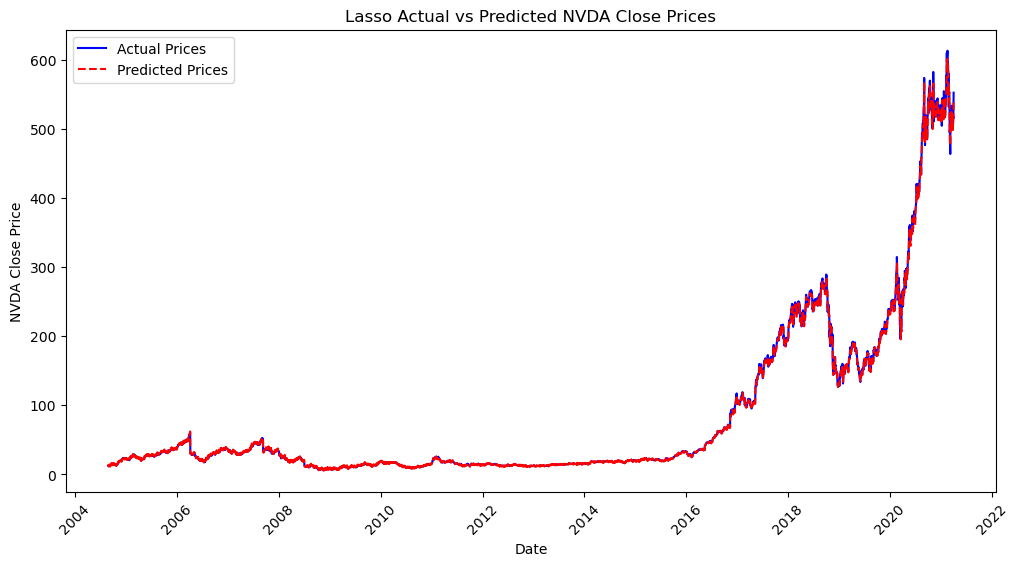

In [552]:
# timeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Store actual and predicted values
all_dates = []
all_actuals = []
all_preds = []


final_lasso = Lasso(alpha=0.001, max_iter=25000)

X['date'] = train_data['date']

X["date"] = X["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

# cross-validation loop
for train, valid in tscv.split(X):
    x_train, x_valid = X.iloc[train], X.iloc[valid]
    y_train, y_valid = y.iloc[train], y.iloc[valid]

    
    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_valid)

    # Collect results
    all_dates.extend(x_valid['date'])
    all_actuals.extend(y_valid)
    all_preds.extend(y_pred)

    # Calculating performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'Validation RMSE: {rmse}')

# Create DataFrame for plotting
results_df = pd.DataFrame({'Date': all_dates, 'Actual': all_actuals, 'Predicted': all_preds})

results_df['Date'] = pd.to_datetime(results_df['Date'], unit='s')

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Lasso Actual vs Predicted NVDA Close Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+04, tolerance: 6.583e+03
  model = cd_fast.enet_coordinate_descent(


Test RMSE: 4.867997496145838


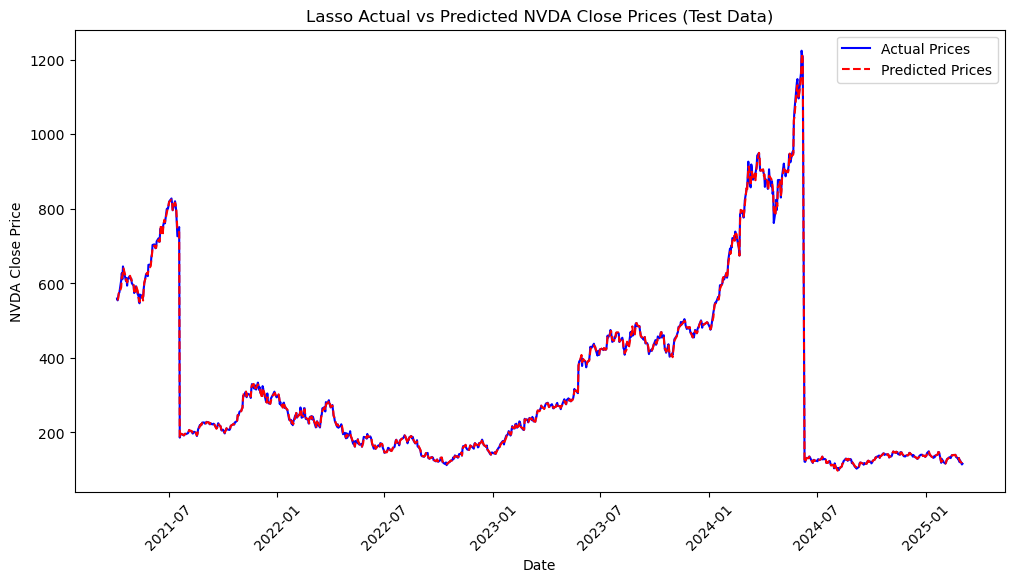

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with featu

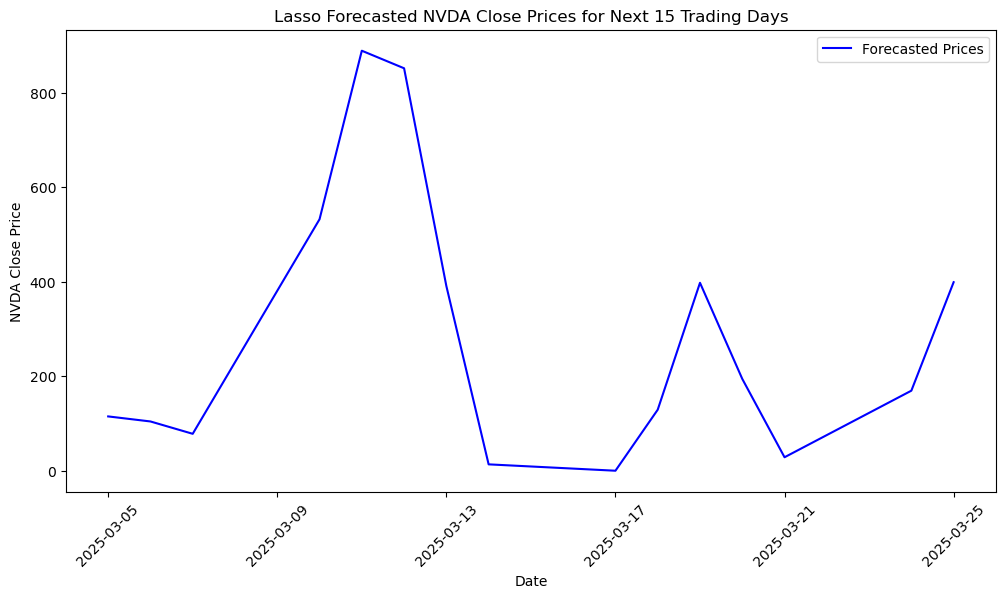

In [553]:
x_test = test_data.drop(columns=['NVDA_close'])
x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_test = test_data['NVDA_close']


final_lasso.fit(X, y)
y_pred = final_lasso.predict(x_test)


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')

x_test['date'] = pd.to_datetime(x_test['date'], unit='s')

# Create DataFrame for test data results
test_results_df = pd.DataFrame({'Date': x_test['date'], 'Actual': y_test, 'Predicted': y_pred})

# Plot actual vs. predicted prices for test data
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=test_results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Lasso Actual vs Predicted NVDA Close Prices (Test Data)")
plt.legend()
plt.xticks(rotation=45)
plt.show()



#################### ----------------------------------------------------------- ##############
# Generating Forecast for the Next 3 Weeks (21 days)

# Convert 'date' to datetime before finding the max date
x_test['date'] = pd.to_datetime(x_test['date'])

# Find the last date in the dataset
last_date = x_test['date'].max()

# Create a new date range for the next 21 days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21, freq='B')


# Initialize the forecast list
forecast_xgb = []

# Use the entire x_test data for the first prediction
last_known_data = x_test.values

for _ in range(15):  # Forecasting for the next 15 trading days
    # Convert Timestamp to numeric (Unix timestamp) if necessary
    if isinstance(last_known_data[0, 0], pd.Timestamp):
        last_known_data[:, 0] = np.array([t.timestamp() for t in last_known_data[:, 0]])

     # Ensure data is float type
    last_known_data = last_known_data.astype(float)

    # Predict the next value using the entire dataset
    pred = final_lasso.predict(last_known_data)[-1]  # Use the last prediction from the model's output
    pred = max(pred, 0)  # Ensure the prediction is not negative
    forecast_xgb.append(pred)
    
    # Append the new prediction to the last_known_data
    new_row = np.roll(last_known_data[-1], -1)  # Shift the last row
    new_row[-1] = pred  # Add the new prediction to the last position
    last_known_data = np.vstack([last_known_data, new_row])  # Append the new row to the dataset

# Create a DataFrame for future dates
future_df = pd.DataFrame({'date': future_dates[:15],  # Assuming future_dates has at least 15 dates
                          'forecasted_prices': forecast_xgb})


# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=future_df, x='date', y='forecasted_prices', label='Forecasted Prices', color='blue')

plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Lasso Forecasted NVDA Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

          date  forecasted_prices    NVDA_close
0  2025-03-05      114.877824864 117.300000000
1  2025-03-06      104.205907523 110.570000000
2  2025-03-07       78.086858100 112.690000000
3  2025-03-10      531.930816747 106.980000000
4  2025-03-11      888.424721668 108.760000000
5  2025-03-12      851.290953895 115.740000000
6  2025-03-13      390.691093459 115.580000000
7  2025-03-14       13.472200469 121.670000000
8  2025-03-17        0.000000000 119.530000000
9  2025-03-18      129.096380757 115.430000000
10 2025-03-19      397.535250089 117.520000000
11 2025-03-20      194.284602830 118.530000000
12 2025-03-21       28.496691581 117.700000000
13 2025-03-24      169.318767026 121.410000000
14 2025-03-25      398.785502769 120.690000000 

Pearson Correlation between forecasted prices and actual prices: -0.4633258271509222  with a p-value of: 0.08196583806374809 
 Spearman Correlation between forecasted prices and actual prices: -0.38214285714285706  with a p-value of: 0.159823629

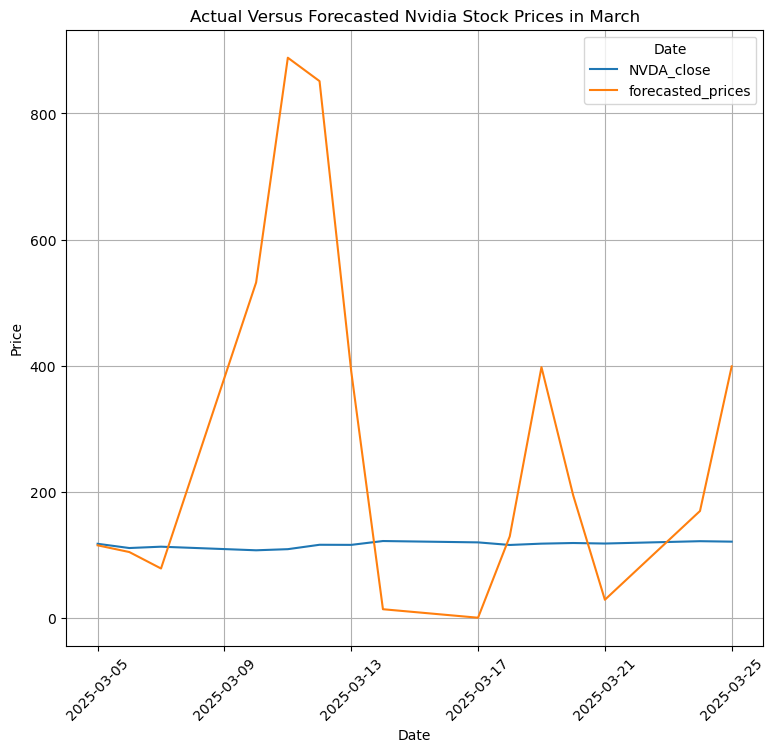

In [554]:
nvidia_march_prices = pd.read_csv("march_prices/NVDA_march_prices.csv")


nvidia_lasso = pd.concat([future_df, nvidia_march_prices['NVDA_close']], axis=1)

print(f" {nvidia_lasso} \n")

# Assuming you have two columns: 'forecasted_prices' and 'NVDA_close'
correlation, p_value = pearsonr(nvidia_lasso['forecasted_prices'], nvidia_lasso['NVDA_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(nvidia_lasso['forecasted_prices'], nvidia_lasso['NVDA_close'])


# Calculate Pearson correlation
correlation = nvidia_lasso[['forecasted_prices', 'NVDA_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((nvidia_lasso['NVDA_close'] - nvidia_lasso['forecasted_prices'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((nvidia_lasso['NVDA_close'] - nvidia_lasso['forecasted_prices']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((nvidia_lasso['NVDA_close'] - nvidia_lasso['forecasted_prices']) / nvidia_lasso['NVDA_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
nvidia_melted = nvidia_lasso.melt(id_vars=['date'],
                               value_vars=['NVDA_close', 'forecasted_prices'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=nvidia_melted, x='date', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Nvidia Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# Sequential LSTM Model for Nvidia 

In [555]:
separate_nvda_data.head()

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
0,1999-01-22,19.690000000,23.440000000,18.630000000,21.000000000,5655600,0.037623625,0.035598178,0.040126771,2714686642,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.360000000,4.440000000,4.460000000,4.590000000,4.580000000,4.540000000,4.730000000,4.640000000,5.380000000,5.090000000,2.190000000,321.050000000,38.000000000,320.000000000,321.050000000,0.657000000,6178.000000000,0.658500000,0.657000000,11.187340531,29891.782535737,11.222459029,11.187340531,5.115000000,0.000000000,5.115000000,5.115000000,286.450000000,0.000000000,287.450000000,286.450000000,0.041601800,100.000000000,0.041601800,0.041601800,0.000000000,0.000000000,0.041601800,-74.180961264,0.041601800,neutral,neutral,1,1999,Winter
1,1999-01-25,21.750000000,22.000000000,19.690000000,21.250000000,1063500,0.041559870,0.037623625,0.040604471,510479744,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.440000000,4.450000000,4.480000000,4.590000000,4.580000000,4.550000000,4.740000000,4.670000000,5.400000000,5.120000000,2.190000000,325.000000000,127.000000000,321.050000000,325.000000000,0.653500000,5340.000000000,0.652000000,0.653500000,11.170448651,29891.782535737,11.191062484,11.170448651,5.185000000,0.000000000,5.100000000,5.185000000,287.850000000,0.000000000,286.450000000,287.850000000,0.041601800,100.000000000,0.041601800,0.041601800,0.000000000,0.000000000,0.041601800,-74.180961264,0.041601800,neutral,neutral,1,1999,Winter
2,1999-01-26,20.060000000,22.440000000,19.750000000,22.000000000,715000,0.038330620,0.037738273,0.042037570,343199828,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.460000000,4.460000000,4.510000000,4.630000000,4.610000000,4.580000000,4.760000000,4.690000000,5.410000000,5.120000000,2.190000000,326.750000000,27.000000000,325.500000000,326.750000000,0.649500000,7328.000000000,0.654000000,0.649500000,11.151174874,29891.782535737,11.200713592,11.151174874,5.115000000,0.000000000,5.175000000,5.115000000,286.150000000,0.000000000,287.750000000,286.150000000,0.041797100,100.000000000,0.041797100,0.041797100,0.000000000,0.000000000,0.041797100,-88.371137703,0.041797100,neutral,neutral,1,1999,Winter
3,1999-01-27,20.000000000,20.630000000,19.000000000,20.130000000,509100,0.038215972,0.036305174,0.038464376,244367877,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.470000000,4.470000000,4.510000000,4.570000000,4.570000000,4.570000000,4.740000000,4.680000000,5.400000000,5.140000000,2.190000000,329.000000000,63.000000000,329.000000000,329.000000000,0.644000000,3401.000000000,0.643000000,0.644000000,11.124727719,29891.782535737,11.147735301,11.124727719,5.095000000,0.000000000,5.115000000,5.095000000,283.0000

In [556]:
separate_nvda_data['date'] = pd.to_datetime(separate_nvda_data['date'])

separate_nvda_data['date_unix'] = separate_nvda_data['date'].astype('int64') // 10**9

s_nvda = separate_nvda_data

# Print the cleaned data
s_nvda.head()

,date,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season,date_unix
0,1999-01-22,19.690000000,23.440000000,18.630000000,21.000000000,5655600,0.037623625,0.035598178,0.040126771,2714686642,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.360000000,4.440000000,4.460000000,4.590000000,4.580000000,4.540000000,4.730000000,4.640000000,5.380000000,5.090000000,2.190000000,321.050000000,38.000000000,320.000000000,321.050000000,0.657000000,6178.000000000,0.658500000,0.657000000,11.187340531,29891.782535737,11.222459029,11.187340531,5.115000000,0.000000000,5.115000000,5.115000000,286.450000000,0.000000000,287.450000000,286.450000000,0.041601800,100.000000000,0.041601800,0.041601800,0.000000000,0.000000000,0.041601800,-74.180961264,0.041601800,neutral,neutral,1,1999,Winter,916963200
1,1999-01-25,21.750000000,22.000000000,19.690000000,21.250000000,1063500,0.041559870,0.037623625,0.040604471,510479744,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.440000000,4.450000000,4.480000000,4.590000000,4.580000000,4.550000000,4.740000000,4.670000000,5.400000000,5.120000000,2.190000000,325.000000000,127.000000000,321.050000000,325.000000000,0.653500000,5340.000000000,0.652000000,0.653500000,11.170448651,29891.782535737,11.191062484,11.170448651,5.185000000,0.000000000,5.100000000,5.185000000,287.850000000,0.000000000,286.450000000,287.850000000,0.041601800,100.000000000,0.041601800,0.041601800,0.000000000,0.000000000,0.041601800,-74.180961264,0.041601800,neutral,neutral,1,1999,Winter,917222400
2,1999-01-26,20.060000000,22.440000000,19.750000000,22.000000000,715000,0.038330620,0.037738273,0.042037570,343199828,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.460000000,4.460000000,4.510000000,4.630000000,4.610000000,4.580000000,4.760000000,4.690000000,5.410000000,5.120000000,2.190000000,326.750000000,27.000000000,325.500000000,326.750000000,0.649500000,7328.000000000,0.654000000,0.649500000,11.151174874,29891.782535737,11.200713592,11.151174874,5.115000000,0.000000000,5.175000000,5.115000000,286.150000000,0.000000000,287.750000000,286.150000000,0.041797100,100.000000000,0.041797100,0.041797100,0.000000000,0.000000000,0.041797100,-88.371137703,0.041797100,neutral,neutral,1,1999,Winter,917308800
3,1999-01-27,20.000000000,20.630000000,19.000000000,20.130000000,509100,0.038215972,0.036305174,0.038464376,244367877,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.470000000,4.470000000,4.510000000,4.570000000,4.570000000,4.570000000,4.740000000,4.680000000,5.400000000,5.140000000,2.190000000,329.000000000,63.000000000,329.000000000,329.000000000,0.644000000,3401.000000000,0.643000000,0.644000000,11.124727719,29891.782535737,11.147735301,11.124727719,5.095000000,0.00

In [557]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(s_nvda[['NVDA_close']])

# Add the scaled values back to the data
s_nvda['NVDA_close_scaled'] = data_scaled

In [558]:
cat_cols = s_nvda.select_dtypes(include='object').columns

# Obtainig Dummies
s_nvda = pd.get_dummies(s_nvda, drop_first=True)

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split data into train and test
split_date = np.quantile(s_nvda['date_unix'], 0.85)
train_data = s_nvda[s_nvda['date_unix'] <= split_date]
test_data = s_nvda[s_nvda['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 27  # Sequence length for LSTM 27

# Use the scaled 'MSFT_close_scaled' column for sequence creation
train_scaled = train_data[['NVDA_close_scaled']].values
test_scaled = test_data[['NVDA_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 175398.1875
Epoch 2/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 172053.5312
Epoch 3/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 168747.9531
Epoch 4/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 165482.1562
Epoch 5/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 162256.9531
Epoch 6/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 159071.4375
Epoch 7/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 155924.5781
Epoch 8/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 152816.7500
Epoch 9/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 149749.2812
Epoch 10/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 146726.6250
Epoch 11/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 143749.4688
Epoch 12/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 140811.7344
Epoch 13/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 137913.2969
Epoch 14/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47

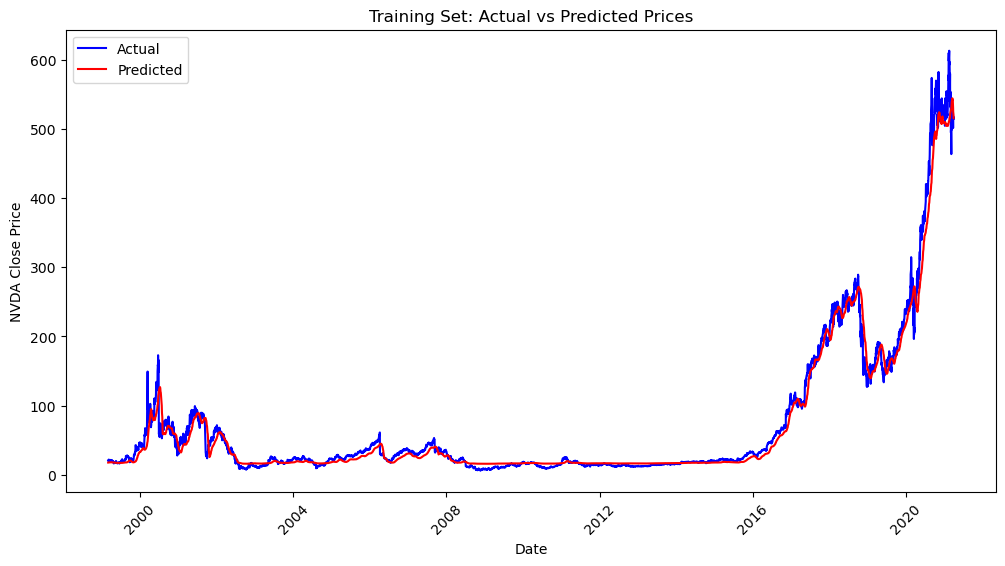

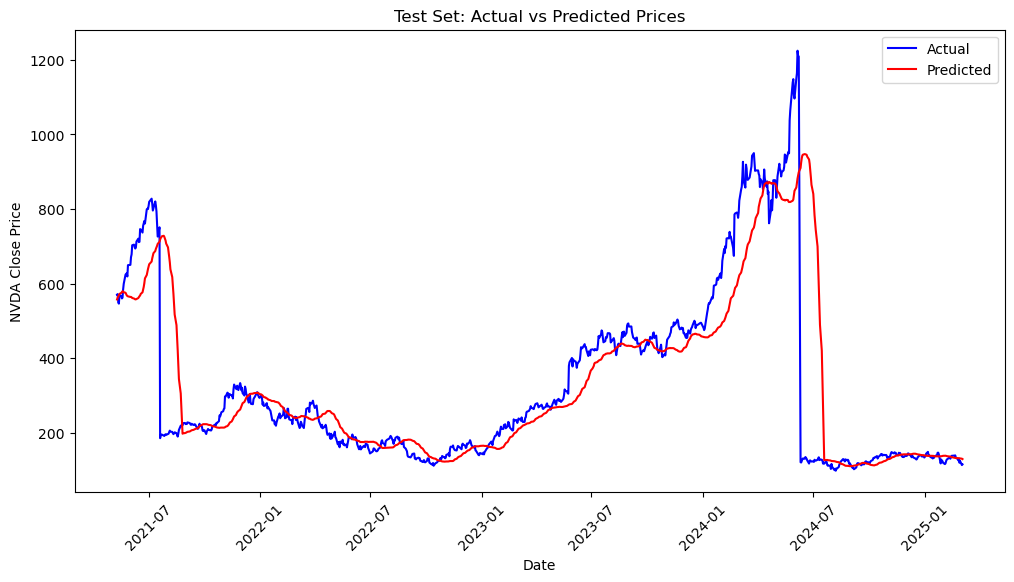

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


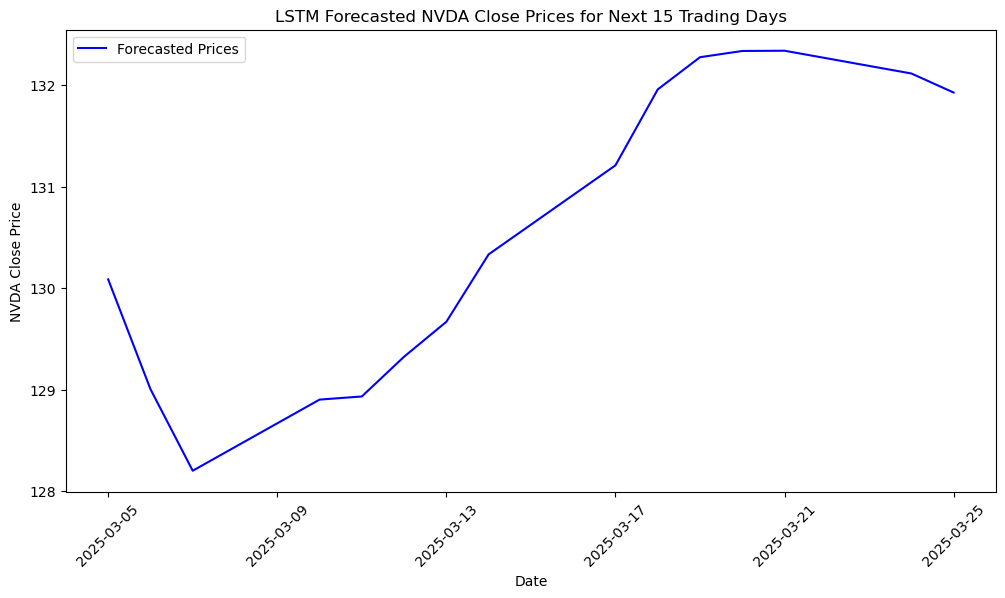

In [559]:
# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l1_l2(200.5, 200.5)))
lstm_model.add(Dropout(0.4)) # Dropout of 40%
BatchNormalization(axis=1)
lstm_model.add(LSTM(60, activation='relu', return_sequences=False, kernel_regularizer=l1_l2(300.5, 200.5)))
lstm_model.add(Dropout(0.5)) # Dropout of 50%
BatchNormalization(axis=1)
lstm_model.add(Dense(20, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))


lr_schedule = ExponentialDecay(initial_learning_rate=0.00001, decay_steps=10000, decay_rate=0.9) # 0.00001
optimizer = AdamW(learning_rate=lr_schedule)

# compiling the model
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training LSTM model 
lstm_model.fit(X_train, y_train, batch_size=40, epochs=40, verbose=1) # 35 25

# Predictions on the test set
y_train_pred = lstm_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = lstm_model.predict(input_seq)[0, 0]
    future_predictions.append(pred)
    new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq


# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='blue')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("LSTM Forecasted NVDA Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions    NVDA_close
0  2025-03-05       130.085784912 117.300000000
1  2025-03-06       129.004379272 110.570000000
2  2025-03-07       128.200454712 112.690000000
3  2025-03-10       128.901245117 106.980000000
4  2025-03-11       128.932052612 108.760000000
5  2025-03-12       129.323928833 115.740000000
6  2025-03-13       129.667831421 115.580000000
7  2025-03-14       130.332260132 121.670000000
8  2025-03-17       131.209533691 119.530000000
9  2025-03-18       131.957153320 115.430000000
10 2025-03-19       132.274765015 117.520000000
11 2025-03-20       132.336181641 118.530000000
12 2025-03-21       132.338668823 117.700000000
13 2025-03-24       132.114364624 121.410000000
14 2025-03-25       131.926696777 120.690000000 

Pearson Correlation between forecasted prices and actual prices: 0.7168749466278954  with a p-value of: 0.0026331947763158304 
 Spearman Correlation between forecasted prices and actual prices: 0.6892857142857142  with a p-value 

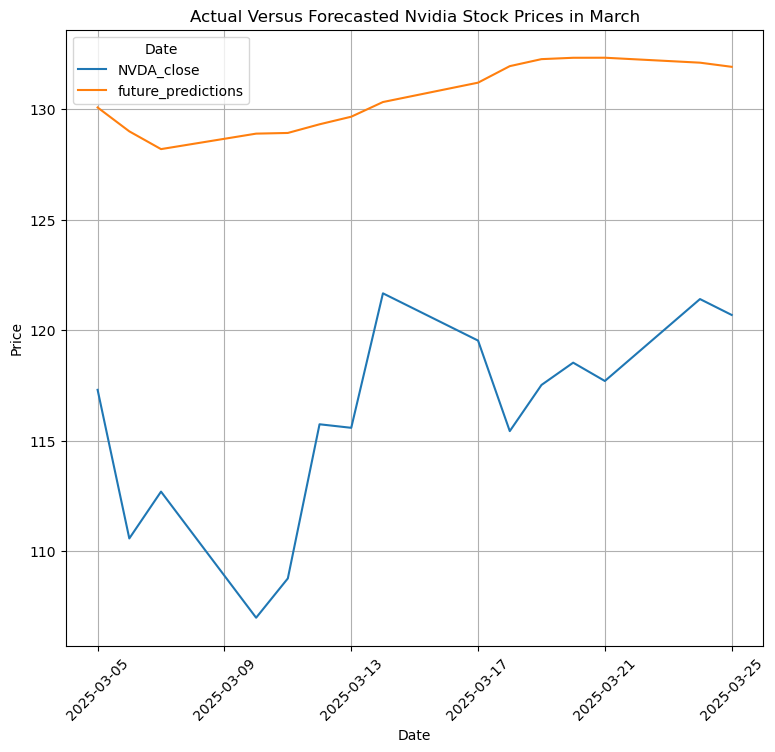

In [560]:
nvidia_lstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})

# nvidia_march_prices = pd.read_csv("march_prices/NVDA_march_prices.csv")


nvidia_lstm = pd.concat([nvidia_lstm, nvidia_march_prices['NVDA_close']], axis=1)

print(f" {nvidia_lstm} \n")

# Assuming you have two columns: 'future_predictions' and 'NVDA_close'
correlation, p_value = pearsonr(nvidia_lstm['future_predictions'], nvidia_lstm['NVDA_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(nvidia_lstm['future_predictions'], nvidia_lstm['NVDA_close'])


# Calculate Pearson correlation
correlation = nvidia_lstm[['future_predictions', 'NVDA_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((nvidia_lstm['NVDA_close'] - nvidia_lstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((nvidia_lstm['NVDA_close'] - nvidia_lstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((nvidia_lstm['NVDA_close'] - nvidia_lstm['future_predictions']) / nvidia_lstm['future_predictions'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
nvidia_melted = nvidia_lstm.melt(id_vars=['date_range'],
                               value_vars=['NVDA_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=nvidia_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Nvidia Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# BI-LSTM Model for Apple

In [564]:
# Split data into train and test
split_date = np.quantile(s_nvda['date_unix'], 0.85)
train_data = s_nvda[s_nvda['date_unix'] <= split_date]
test_data = s_nvda[s_nvda['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Sequence length for Bi-LSTM 27

# Use the scaled 'MSFT_close_scaled' column for sequence creation
train_scaled = train_data[['NVDA_close_scaled']].values
test_scaled = test_data[['NVDA_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - loss: 648938.5625
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 632556.1250
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 616436.1250
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 600584.6875
Epoch 5/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 584990.5000
Epoch 6/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 569660.7500
Epoch 7/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 554583.1875
Epoch 8/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 539755.0625
Epoch 9/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 525156.1875
Epoch 10/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 510791.5938
Epoch 11/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 496667.1562
Epoch 12/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 482796.3125
Epoch 13/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - loss: 469160.2812
Epoch 14/25
174/174 ━━━━━━━━━━━━━━

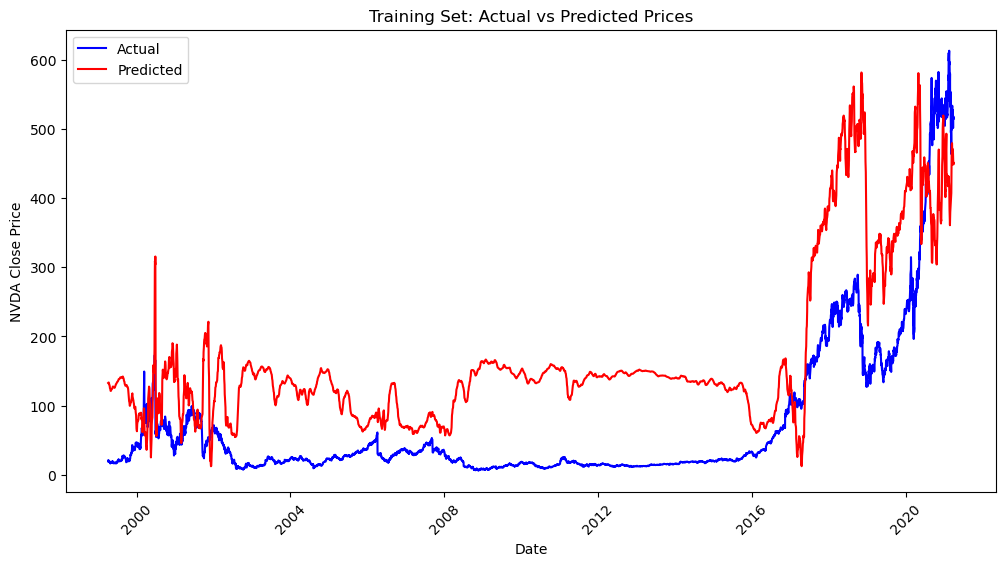

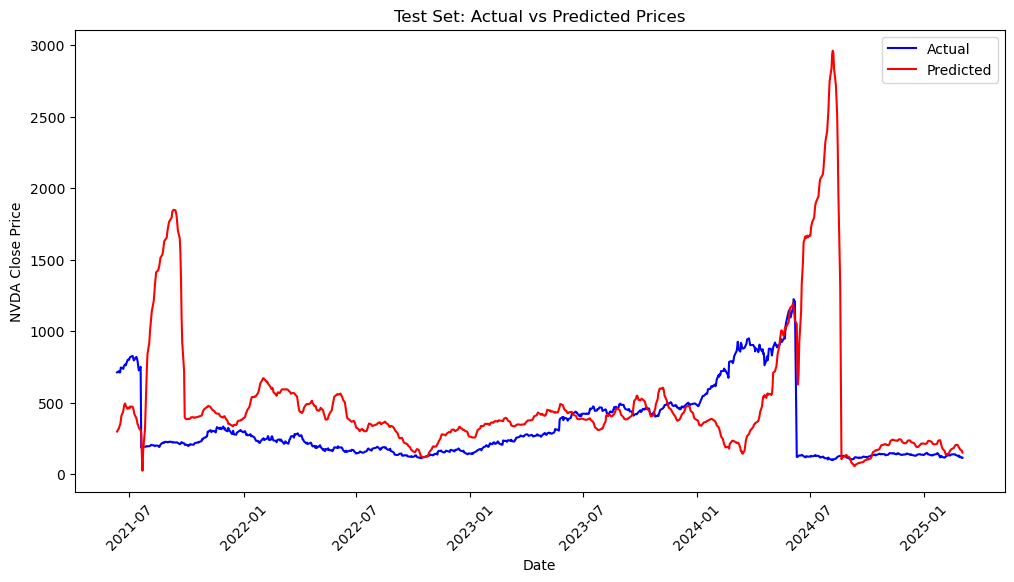

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


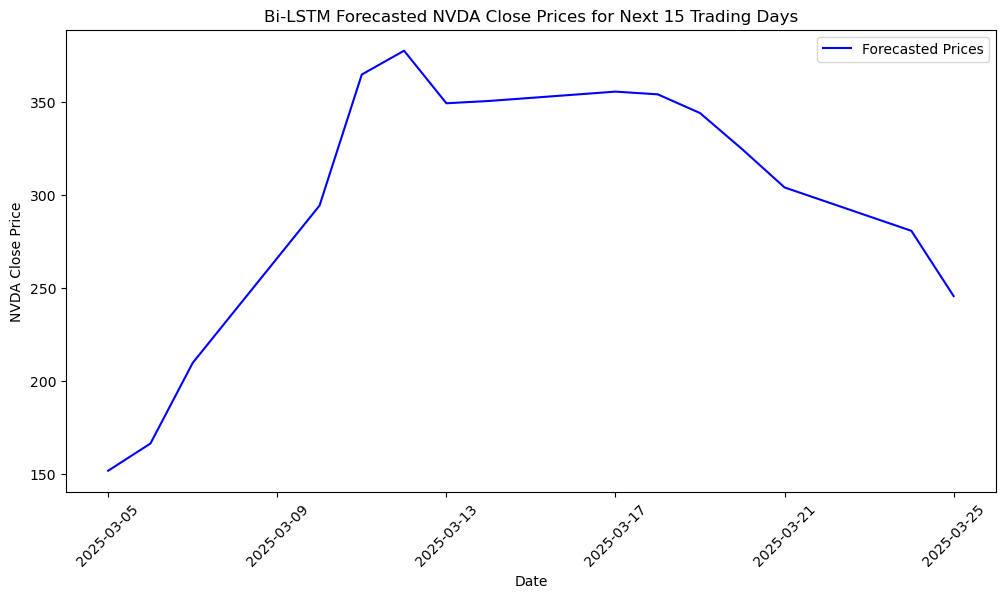

In [565]:
# Define Bidirectional LSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(30, activation='relu', kernel_regularizer=l1_l2(200.5, 200.5), return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(60, activation='relu', kernel_regularizer=l1_l2(300.5, 200.5), return_sequences=False), input_shape=(seq_length, 1)),
    Dropout(0.3),
    BatchNormalization(),
    # Bidirectional(LSTM(30, activation='relu', kernel_regularizer=l1_l2(300.5, 200.5), return_sequences=False), input_shape=(seq_length, 1)),
    # Dropout(0.3),
    # BatchNormalization(),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])


lr_schedule = ExponentialDecay(initial_learning_rate=0.00001, decay_steps=10000, decay_rate=0.9)
bilstm_optimizer = AdamW(learning_rate=lr_schedule)

# Compile the bi-lstm model
bilstm_model.compile(optimizer=bilstm_optimizer, loss='mean_squared_error')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=25, batch_size=32)

# Predictions on the training set
y_train_pred = bilstm_model.predict(X_train)
# y_train_pred = y_train_pred[:, -1, 0]  # Take the last time step's prediction
y_train_pred = y_train_pred[:, 0]  # Take the first (or appropriate) feature
y_train_pred = y_train_pred.reshape(-1, 1)  # Ensure 2D shape
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = bilstm_model.predict(X_test)
# y_pred = y_pred[:, -1, 0]  # Take the last time step's prediction
y_pred = y_pred[:, 0]  # Take the first (or appropriate) feature
y_pred = y_pred.reshape(-1, 1)  # Ensure 2D shape
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = bilstm_model.predict(input_seq)[0, 0]
    pred = np.array(pred).reshape(1, 1, 1)  # Replace `num_features` with the correct value
    new_seq = np.append(input_seq[:, 1:, :], pred, axis=1)

    future_predictions.append(pred)
    # new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq

# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='blue')
plt.xlabel("Date")
plt.ylabel("NVDA Close Price")
plt.title("Bi-LSTM Forecasted NVDA Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions    NVDA_close
0  2025-03-05       151.863891602 117.300000000
1  2025-03-06       166.480087280 110.570000000
2  2025-03-07       209.804534912 112.690000000
3  2025-03-10       294.316223145 106.980000000
4  2025-03-11       364.736206055 108.760000000
5  2025-03-12       377.510833740 115.740000000
6  2025-03-13       349.290100098 115.580000000
7  2025-03-14       350.502441406 121.670000000
8  2025-03-17       355.537109375 119.530000000
9  2025-03-18       354.084228516 115.430000000
10 2025-03-19       344.031921387 117.520000000
11 2025-03-20       324.567382812 118.530000000
12 2025-03-21       304.067382812 117.700000000
13 2025-03-24       280.760131836 121.410000000
14 2025-03-25       245.688095093 120.690000000 

Pearson Correlation between forecasted prices and actual prices: 0.13040740361662445  with a p-value of: 0.64319522604776 
 Spearman Correlation between forecasted prices and actual prices: 0.024999999999999998  with a p-value of

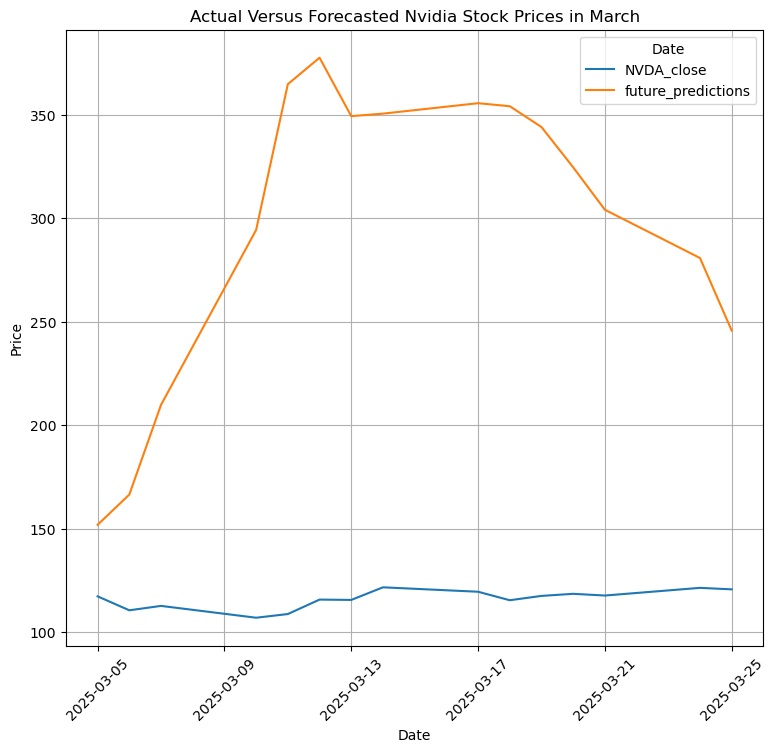

In [566]:
nvidia_bilstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})

# nvidia_march_prices = pd.read_csv("march_prices/NVDA_march_prices.csv")


nvidia_bilstm = pd.concat([nvidia_bilstm, nvidia_march_prices['NVDA_close']], axis=1)


print(f" {nvidia_bilstm} \n")

# Assuming you have two columns: 'future_predictions' and 'NVDA_close'
correlation, p_value = pearsonr(nvidia_bilstm['future_predictions'], nvidia_bilstm['NVDA_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(nvidia_bilstm['future_predictions'], nvidia_bilstm['NVDA_close'])


# Calculate Pearson correlation
correlation = nvidia_bilstm[['future_predictions', 'NVDA_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((nvidia_bilstm['NVDA_close'] - nvidia_bilstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((nvidia_bilstm['NVDA_close'] - nvidia_bilstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((nvidia_bilstm['NVDA_close'] - nvidia_bilstm['future_predictions']) / nvidia_bilstm['future_predictions'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
nvidia_melted = nvidia_bilstm.melt(id_vars=['date_range'],
                               value_vars=['NVDA_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=nvidia_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Nvidia Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()